In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import src.model_builder as mb
import src.data_handling as dh
import src.modules as modules

In [2]:
from tqdm.notebook import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
genes = ["ESR1"]

In [5]:
model = mb.CellLevelModel("Cancer", genes)

### Load models

In [ ]:
for gene in genes:
    filename = "/data/severs/saved_models/Cancer_diff_exp_" + gene
    model.models[gene] = pickle.load(open(filename, "rb"))

Loads positive model from `Regression-positive_esr1_xavier`

In [ ]:
filename = "/data/severs/saved_models/Cancer_positive_exp_05_ESR1"
pickle.dump(model["ESR1"], open(filename, "wb"))

Build previous datasets to choose overlapping genes between new and old dataset. The shapley values are also computed to measure the importance of the missing genes. 

In [29]:
model.build_datasets(positive_exp=True, diff_lim=0.5)

Getting data for ESR1
Selected 1002 input genes with alpha = 4e-19


In [7]:
params = {'objective': 'reg:squarederror',
 'importance_type': 'gain',
 'learning_rate': 0.04,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 1000,
 'n_jobs': 40,
 'subsample': 1,
 'verbosity': 0,
 'seed': 1,
 'silent': True}

In [8]:
model.build_model(params)


CANCER - ESR1 

   ESR1:
      Performing 5 fold cross-validation on ESR1 -  487 iters
      rmse: 0.882151
      Building regression model for ESR1, n_estimators=487 ... Complete
MODEL BUILDING COMPLETE




In [9]:
model.shap_analysis("ESR1", interaction=False)

Calculating shap_values for ESR1... Completed
Shap analysis completed


## Finding missing genes in new dataset

In [31]:
shap_vals = model.shapley["ESR1"]["shap_vals"]

In [32]:
abs_shap = np.abs(shap_vals).mean(axis=0)
sorter = np.argsort(abs_shap)

In [33]:
shap_rank = model.datasets["ESR1"]["X_train"].columns[sorter]

In [34]:
df_ = pd.read_pickle("/data/severs/correlation_p_values/Cancer_baseline_ESR1_correlation_expdiff_0.5.pkl")

In [35]:
missing_ranks = []
missing_genes = []
present_genes = []
for i, gene in enumerate(shap_rank):
    if gene not in df_.index:
        missing_ranks.append(i)
        missing_genes.append(gene)
    else:
        present_genes.append(gene)

## Use the old model on the new dataset

In [36]:
X, Y = model.get_data("ESR1")

In [37]:
X = X.drop(missing_genes, axis=1)

In [38]:
model.set_data(X, Y, "ESR1")

In [18]:
params = {'objective': 'reg:squarederror',
 'importance_type': 'gain',
 'learning_rate': 0.04,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 487,
 'n_jobs': 40,
 'subsample': 1,
 'verbosity': 0,
 'seed': 1,
 'silent': True}

The model is first trained again on the old dataset with the subset of the selected genes that is present in the new dataset. This seems to have little effect on the results with a small drop of 0.03 in the RMSE. 

In [19]:
model.build_model(params, ["ESR1"], early_stopping_rounds=None)


CANCER - ESR1 

   ESR1:
      Performing 5 fold cross-validation on ESR1 -  486 iters
      rmse: 0.8693198000000001
      Building regression model for ESR1, n_estimators=486 ... Complete
MODEL BUILDING COMPLETE




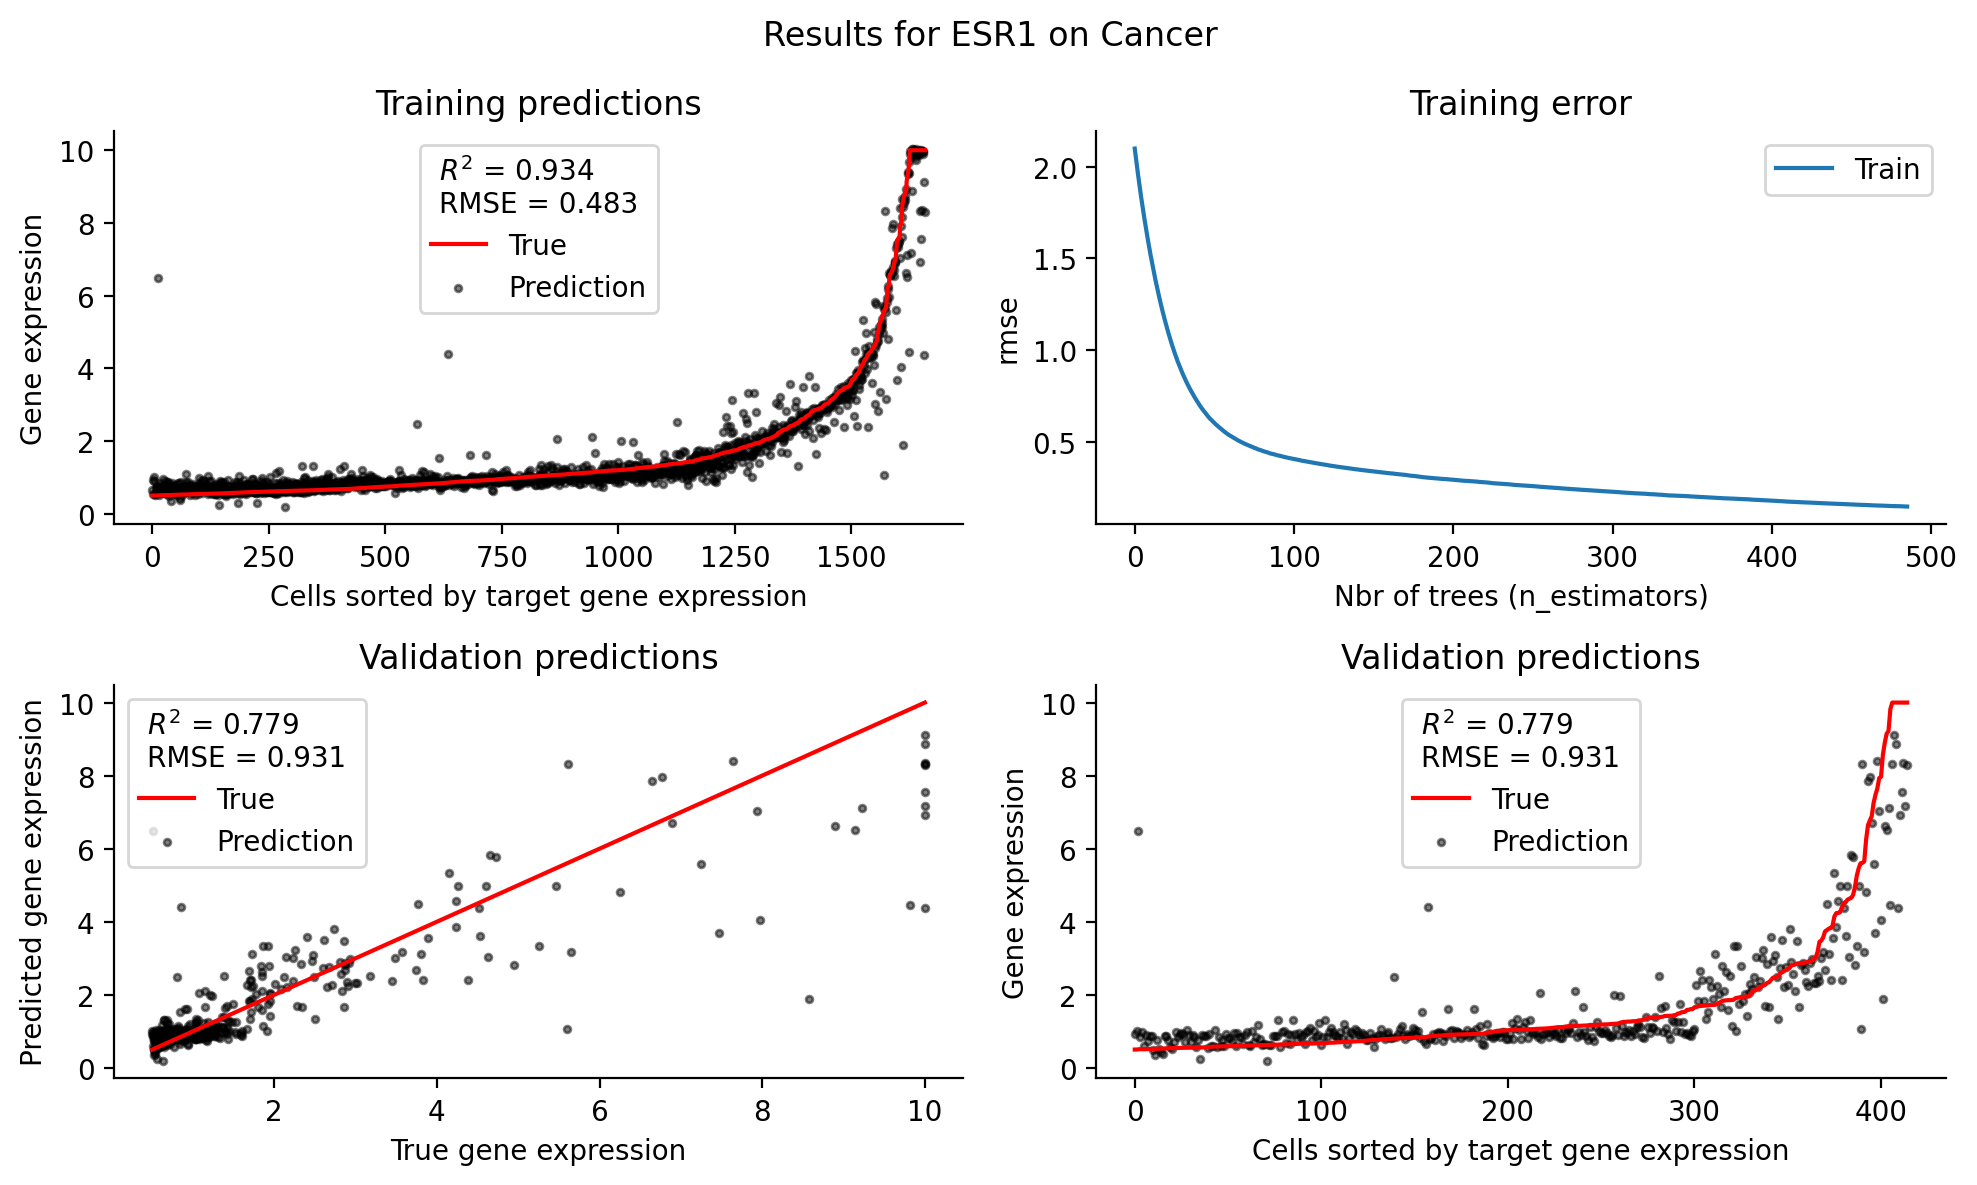

In [45]:
model.plot_results("ESR1")
import matplotlib.pyplot as plt
plt.show()

In [63]:
(model.datasets["ESR1"]["X_train"].columns == X_val_new.columns).sum()/len(X_val_new.columns)

1.0

In [47]:
df_baseline = pd.read_pickle("/data/severs/reduced_data_sets/Cancer_baseline.pkl")

#### Only using positively expressed data

In [73]:
X_val_new = df_baseline[present_genes]
Y_val = df_baseline["ESR1"]

In [74]:
X_val_new = X_val_new[Y_val>0.5]

In [75]:
Y_val = Y_val[Y_val>0.5]

In [79]:
X_val_new = X_val_new.reindex(X.columns, axis=1)

In [80]:
y_pred = model["ESR1"].predict(X_val_new)

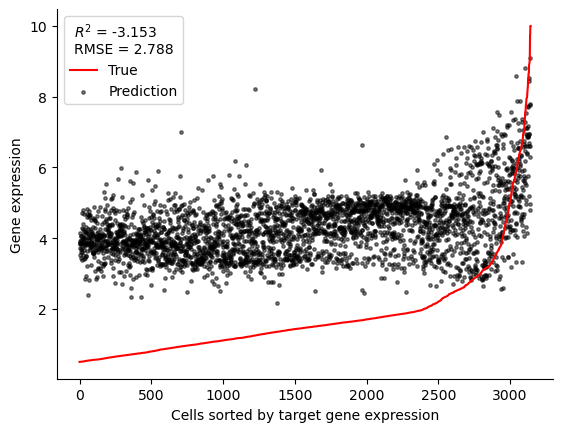

In [81]:
modules.plot_prediction(Y_val.values, y_pred)

In [ ]:
model.datasets["ESR1"]["X_val"] = X_val

In [ ]:
model.shap_analysis("ESR1", interaction=False)

We see that the model cannot extrapolate to the new dataset.

### Train on baseline

In [82]:
model_2 = mb.CellLevelModel("Cancer_baseline", ["ESR1"])

In [83]:
model_2.build_datasets(positive_exp=True, diff_lim=0.5)

Getting data for ESR1
Selected 1000 input genes with alpha = 7.000000000000001e-23


In [84]:
model_2.build_model(params)


CANCER_BASELINE - ESR1 

   ESR1:
      Performing 5 fold cross-validation on ESR1 -  248 iters
      rmse: 0.5705472
      Building regression model for ESR1, n_estimators=248 ... Complete
MODEL BUILDING COMPLETE




In [85]:
y_pred = model_2.predict("ESR1", "X_val")

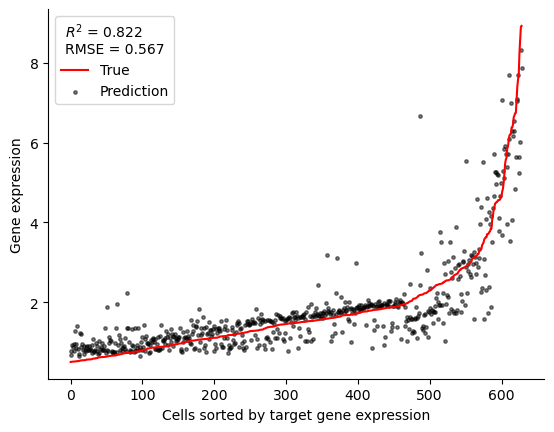

In [86]:
modules.plot_prediction(model_2.datasets["ESR1"]["y_val"].values, y_pred)

## Train on positively expressed baseline

In [ ]:
model_3 = mb.CellLevelModel("Cancer_baseline", ["ESR1"])

In [ ]:
model_3.build_datasets(diff_lim=0.3, positive_exp=True)

In [ ]:
model_3.build_model(params)

In [ ]:
y_pred_3 = model_3.predict("ESR1", "X_val")

In [ ]:
model_3.datasets["ESR1"]["y_train"]

In [ ]:
modules.plot_prediction(model_3.datasets["ESR1"]["y_val"].values, y_pred_3)

## Test of model on 2mnd test

In [ ]:
selected_v = model_3.datasets["ESR1"]["X_val"].columns

In [ ]:
df_2mnd = pd.read_pickle("/data/severs/reduced_data_sets/Cancer_2mnd.pkl")

X_2mnd = df_2mnd[selected_v]
Y_2mnd = df_2mnd["ESR1"]
X_2mnd = X_2mnd.reindex(selected_v, axis=1)
X_2mnd = X_2mnd[Y_2mnd>0.3]
Y_2mnd = Y_2mnd[Y_2mnd>0.3]

In [ ]:
y_pred_2mnd = model_3["ESR1"].predict(X_2mnd)

In [ ]:
modules.plot_prediction(Y_2mnd.values, y_pred_2mnd)

Performance on 2mnd is very bad. And there seems to be significant differences between the datasets

## Test of model on 4mnd test
There are much fewer samples meeting the criteria in 4mnd dataset. 

In [ ]:
selected_v = model_3.datasets["ESR1"]["X_val"].columns

In [ ]:
df_4mnd = pd.read_pickle("/data/severs/reduced_data_sets/Cancer_4mnd.pkl")

X_4mnd = df_4mnd[selected_v]
Y_4mnd = df_4mnd["ESR1"]

X_4mnd = X_4mnd.reindex(selected_v, axis=1)
X_4mnd = X_4mnd[Y_4mnd>0.3]
Y_4mnd = Y_4mnd[Y_4mnd>0.3]

In [ ]:
y_pred_4mnd = model_3["ESR1"].predict(X_4mnd)

In [ ]:
modules.plot_prediction(Y_4mnd.values, y_pred_4mnd)

## Difference in data sets
The expression of ESR1 decreases with treatment. We should also find a similarity measure between the entire range of input values to see if they change. 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
sorter = np.argsort(df_baseline["ESR1"].values)
ax.plot(df_baseline["ESR1"].values[sorter], label="Baseline")
sorter = np.argsort(df_2mnd["ESR1"].values)
ax.plot(df_2mnd["ESR1"].values[sorter], label="2 months")
sorter = np.argsort(df_4mnd["ESR1"].values)
ax.plot(df_4mnd["ESR1"].values[sorter], label="4 months")
plt.legend()